In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import plotly.express as px
from textwrap import indent

In [2]:
def box_summary(
    df: pd.DataFrame,
    value_col: str,
    *,
    group_cols=("clima", "estrato", "m2"),
    total_viviendas: int | None = None
) -> pd.DataFrame:
    """
    Resume la distribución de `value_col` para cada combinación de `group_cols`.

    Parámetros
    ----------
    df : DataFrame ya *expandido* (cada fila cuenta 1 vez).
    value_col : columna numérica a resumir (p.ej. 'kwh_mes', 'kwh_m2persona').
    group_cols : tupla/lista de columnas de agrupamiento.
    total_viviendas : total con que normalizar la columna 'n'; si es None,
                      no se añade la columna 'pct_viv'.

    Devuelve
    --------
    DataFrame con columnas:
      group_cols + [n, minimo, Q1, mediana, Q3, maximo, media, (pct_viv)]
    """
    grp = df.groupby(list(group_cols))[value_col]

    resumen = (
        grp.agg(
            n       = "size",
            minimo  = "min",
            Q1      = lambda s: s.quantile(0.25),
            mediana = "median",
            Q3      = lambda s: s.quantile(0.75),
            maximo  = "max",
            media   = "mean",
        )
        .reset_index()
    )

    # Añade el porcentaje si se proporciona el total
    if total_viviendas is not None:
        resumen["pct_viv"] = (resumen["n"] / total_viviendas) * 100
        resumen["pct_viv"] = resumen["pct_viv"].round(2)

    return resumen

def make_box_tables(
    resumen: pd.DataFrame,
    *,
    climates: list[str] | None = None,
    estrato_order: list[str] | None = None,
    pct_col: str = "porcentaje",      # ← nombre de la columna a añadir
    pct_name: str = "%Viviendas"      # ← nombre que aparecerá en la tabla
) -> dict[tuple[str, str], pd.DataFrame]:
    """
    Crea un diccionario de DataFrames con las estadísticas (P25, Mediana, Media,
    P75) *más* el porcentaje de viviendas para cada combinación clima-estrato.

    Parameters
    ----------
    resumen : DataFrame
        Debe contener: clima, estrato, m2, Q1, mediana, media, Q3 y `pct_col`.
    climates : lista explícita de climas a incluir (default: todos).
    estrato_order : orden deseado de estratos (default: ['Bajo','Medio bajo',…]).
    pct_col : nombre de la columna en `resumen` con el porcentaje.
    pct_name : encabezado que se mostrará en la tabla para ese porcentaje.

    Returns
    -------
    dict { (clima, estrato) : DataFrame }
        Columnas por defecto:
        ['m²', 'P25', 'Mediana', 'Media', 'P75', '%Viviendas']
    """
    if climates is None:
        climates = sorted(resumen["clima"].unique())
    if estrato_order is None:
        estrato_order = ["Bajo", "Medio bajo", "Medio alto", "Alto"]

    tables: dict[tuple[str, str], pd.DataFrame] = {}

    for clima in climates:
        df_clima = resumen[resumen["clima"] == clima]
        for estrato in estrato_order:
            sub = df_clima[df_clima["estrato"] == estrato].copy()
            if sub.empty:
                continue

            tidy = (
                sub[["m2", "Q1", "mediana", "media", "Q3", pct_col]]
                .rename(
                    columns={
                        "m2": "m²",
                        "Q1": "P25",
                        "mediana": "Mediana",
                        "media": "Media",
                        "Q3": "P75",
                        pct_col: pct_name,
                    }
                )
                .sort_values("m²", kind="mergesort")   # orden estable
                .reset_index(drop=True)
            )
            tables[(clima, estrato)] = tidy

    return tables



# --- 2.  Función auxiliar: DataFrame → Markdown (sin índice, 2 decimales) ----
def df_to_md(df: pd.DataFrame) -> str:
    """
    Devuelve una cadena en formato GitHub-Markdown con 2 decimales
    y sin columna índice.
    """
    return df.round(2).to_markdown(index=False)

In [3]:
total_viviendas = 33_162_148

In [4]:
f ="../data/002_intermediate/vivienda_sin_aa.parquet"
viv =pd.read_parquet(f)
f = "../data/002_intermediate/porcentajes_naa.parquet"
porcentajes_naa = pd.read_parquet(f)
viv.factor.sum()
viv.columns

Index(['clima', 'factor', 'personas', 'm2', 'estrato', 'kwh_mes', 'kwh_m2',
       'kwh_persona', 'kwh_m2persona'],
      dtype='object')

In [5]:
viv.factor.sum()/total_viviendas*100

np.float64(42.53378279356331)

In [6]:
viv_expandida = viv.loc[viv.index.repeat(viv["factor"])].reset_index(drop=True)
viv_expandida.info()

ERROR! Session/line number was not unique in database. History logging moved to new session 596
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14118022 entries, 0 to 14118021
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   clima          object 
 1   factor         int64  
 2   personas       int64  
 3   m2             float64
 4   estrato        object 
 5   kwh_mes        float64
 6   kwh_m2         float64
 7   kwh_persona    float64
 8   kwh_m2persona  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 969.4+ MB


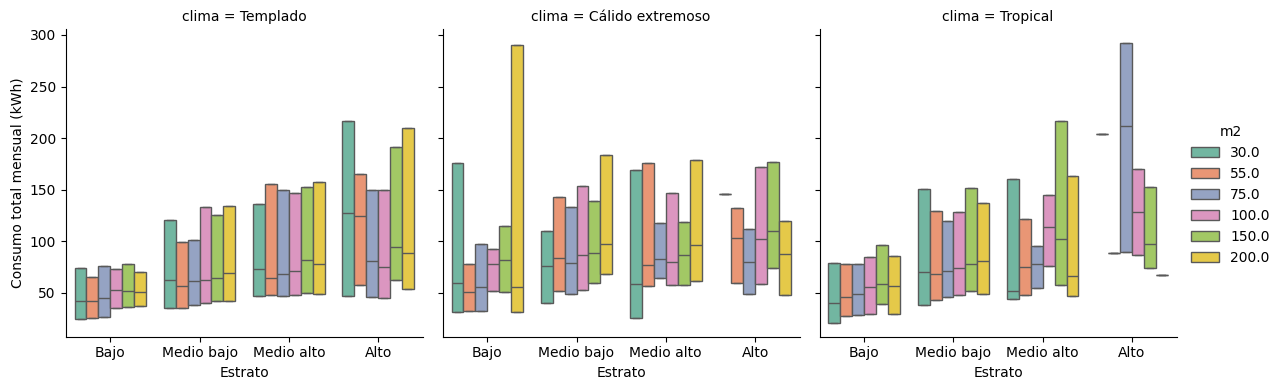

In [7]:
#| label: fig-mensual-sin-aa
#| fig-cap: Consumo total mensual de la vivienda para los diferentes climas y estratos socioeconómicos y sin uso de aire acondicionado.

m2_list = sorted(viv['m2'].unique())
colors = sns.color_palette('Set2', n_colors=len(m2_list))
palette_dict = {m2: colors[i] for i, m2 in enumerate(m2_list)}
estrato_order = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']


g = sns.catplot(
    data=viv_expandida,
    x='estrato',
    y='kwh_mes',
    hue='m2',
    palette=palette_dict,
    col='clima',
    kind='box',
    order=estrato_order,
    col_wrap=3,
    height=4,
    sharey=True,
    whis=[25, 75],
    showfliers=False,
    legend=True,
)

g.set_axis_labels("Estrato", "Consumo total mensual (kWh)")

In [8]:
viv_expandida.columns

Index(['clima', 'factor', 'personas', 'm2', 'estrato', 'kwh_mes', 'kwh_m2',
       'kwh_persona', 'kwh_m2persona'],
      dtype='object')

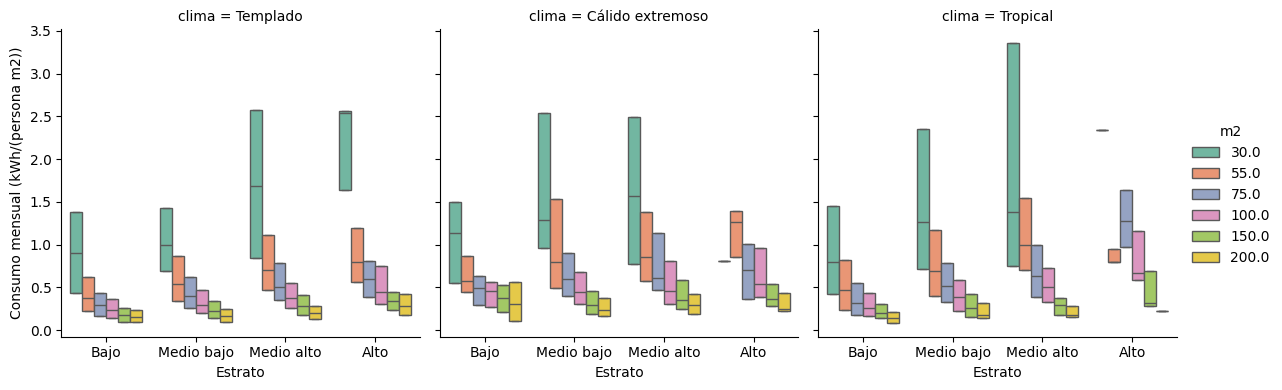

In [9]:
#| label: fig-mensual-personam2-sin-aa
#| fig-cap: Consumo total mensual de la vivienda para los diferentes climas y estratos socioeconómicos y sin uso de aire acondicionado.

m2_list = sorted(viv['m2'].unique())
colors = sns.color_palette('Set2', n_colors=len(m2_list))
palette_dict = {m2: colors[i] for i, m2 in enumerate(m2_list)}
estrato_order = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']


g = sns.catplot(
    data=viv_expandida,
    x='estrato',
    y='kwh_m2persona',
    hue='m2',
    palette=palette_dict,
    col='clima',
    kind='box',
    order=estrato_order,
    col_wrap=3,
    height=4,
    sharey=True,
    whis=[25, 75],
    showfliers=False,
    legend=True,
)

g.set_axis_labels("Estrato", "Consumo mensual (kWh/(persona m2))")

In [10]:
viv_expandida.columns

Index(['clima', 'factor', 'personas', 'm2', 'estrato', 'kwh_mes', 'kwh_m2',
       'kwh_persona', 'kwh_m2persona'],
      dtype='object')

In [11]:
tabla_kwh = box_summary(viv_expandida, "kwh_mes",total_viviendas=None)
tabla_kwhm2persona = box_summary(viv_expandida, "kwh_m2persona",total_viviendas=None)

tabla_kwh, tabla_kwhm2persona

(               clima     estrato     m2       n      minimo          Q1  \
 0   Cálido extremoso        Alto   30.0    1229  145.571776  145.571776   
 1   Cálido extremoso        Alto   55.0    7126   12.388057   59.730411   
 2   Cálido extremoso        Alto   75.0   36110   35.685196   48.703435   
 3   Cálido extremoso        Alto  100.0   71256   10.763536   58.102477   
 4   Cálido extremoso        Alto  150.0   49536   31.257106   73.679802   
 ..               ...         ...    ...     ...         ...         ...   
 67          Tropical  Medio bajo   55.0  297002    7.839084   42.708645   
 68          Tropical  Medio bajo   75.0  260584   12.003597   45.371782   
 69          Tropical  Medio bajo  100.0  257920   12.248568   47.341210   
 70          Tropical  Medio bajo  150.0  176378    9.806510   51.843619   
 71          Tropical  Medio bajo  200.0   85664   11.268683   48.557980   
 
        mediana          Q3       maximo       media  
 0   145.571776  145.571776   1

In [12]:
# 1) -—  verifica que las tres llaves tengan el mismo tipo en ambos DataFrames
for col in ["clima", "estrato"]:
    porcentajes_naa[col] = porcentajes_naa[col].astype(str)
    tabla_kwh[col]              = tabla_kwh[col].astype(str)

# `m2` suele ser float (30.0, 55.0, …).  
# Si en alguno viene como int, conviértelo a float para que la fusión encuentre coincidencias.
tabla_kwh["m2"]              = tabla_kwh["m2"].astype(float)
porcentajes_naa["m2"] = porcentajes_naa["m2"].astype(float)

# 2) -—  selecciona solo la columna que quieres añadir
cols_pct = porcentajes_naa[["clima", "estrato", "m2", "porcentaje"]]

# 3) -—  fusiona (left join) y conserva el orden original de `tabla_kwh`
tabla_kwh = (
    tabla_kwh
    .merge(cols_pct, on=["clima", "estrato", "m2"], how="left")
    .sort_values(["clima", "estrato", "m2"], ignore_index=True)
)

# 4) -—  (opcional) comprueba si hubo filas sin coincidencia
missing = tabla_kwh["porcentaje"].isna().sum()
if missing:
    print(f"⚠️  {missing} filas no hallaron su 'porcentaje'. Revisa claves o tipos.")

# Resultado
tabla_kwh


,clima,estrato,m2,n,minimo,Q1,mediana,Q3,maximo,media,porcentaje
0,Cálido extremoso,Alto,30.0,1229,145.571776,145.571776,145.571776,145.571776,145.571776,145.571776,0.006972
1,Cálido extremoso,Alto,55.0,7126,12.388057,59.730411,103.077720,132.315645,205.040754,107.930726,0.052702
2,Cálido extremoso,Alto,75.0,36110,35.685196,48.703435,80.131243,111.982483,363.000000,106.901201,0.122646
3,Cálido extremoso,Alto,100.0,71256,10.763536,58.102477,102.422142,171.595771,411.372234,127.979089,0.257670
4,Cálido extremoso,Alto,150.0,49536,31.257106,73.679802,110.302068,176.383498,459.131591,136.172468,0.197728
...,...,...,...,...,...,...,...,...,...,...,...
67,Tropical,Medio bajo,55.0,297002,7.839084,42.708645,68.289149,128.801180,587.690476,100.831593,1.400714
68,Tropical,Medio bajo,75.0,260584,12.003597,45.371782,71.500631,119.567304,716.302768,97.883673,1.052643
69,Tropical,Medio bajo,100.0,257920,12.248568,47.341210,73.731473,128.545477,525.065621,103.287282,1.065272
70,Tropical,Medio bajo,150.0,176378,9.806510,51.843619,77.787295,151.504110,1167.974661,122.201690,0.710397


In [13]:
# 1) -—  verifica que las tres llaves tengan el mismo tipo en ambos DataFrames
for col in ["clima", "estrato"]:
    porcentajes_naa[col] = porcentajes_naa[col].astype(str)
    tabla_kwhm2persona[col]              = tabla_kwhm2persona[col].astype(str)

# `m2` suele ser float (30.0, 55.0, …).  
# Si en alguno viene como int, conviértelo a float para que la fusión encuentre coincidencias.
tabla_kwhm2persona["m2"]              = tabla_kwhm2persona["m2"].astype(float)
porcentajes_naa["m2"] = porcentajes_naa["m2"].astype(float)

# 2) -—  selecciona solo la columna que quieres añadir
cols_pct = porcentajes_naa[["clima", "estrato", "m2", "porcentaje"]]

# 3) -—  fusiona (left join) y conserva el orden original de `tabla_kwh`
tabla_kwhm2persona = (
    tabla_kwhm2persona
    .merge(cols_pct, on=["clima", "estrato", "m2"], how="left")
    .sort_values(["clima", "estrato", "m2"], ignore_index=True)
)

# 4) -—  (opcional) comprueba si hubo filas sin coincidencia
missing = tabla_kwhm2persona["porcentaje"].isna().sum()
if missing:
    print(f"⚠️  {missing} filas no hallaron su 'porcentaje'. Revisa claves o tipos.")

# Resultado
tabla_kwhm2persona


,clima,estrato,m2,n,minimo,Q1,mediana,Q3,maximo,media,porcentaje
0,Cálido extremoso,Alto,30.0,1229,0.808732,0.808732,0.808732,0.808732,0.808732,0.808732,0.006972
1,Cálido extremoso,Alto,55.0,7126,0.442967,0.855374,1.270251,1.395767,1.933910,1.224095,0.052702
2,Cálido extremoso,Alto,75.0,36110,0.233264,0.368985,0.698638,1.003724,2.794552,0.820839,0.122646
3,Cálido extremoso,Alto,100.0,71256,0.148298,0.388925,0.542994,0.959881,3.312672,0.836650,0.257670
4,Cálido extremoso,Alto,150.0,49536,0.144320,0.277798,0.362310,0.544142,1.242092,0.444720,0.197728
...,...,...,...,...,...,...,...,...,...,...,...
67,Tropical,Medio bajo,55.0,297002,0.073962,0.396634,0.695607,1.177316,6.478003,0.934343,1.400714
68,Tropical,Medio bajo,75.0,260584,0.063500,0.332072,0.517103,0.790411,3.774090,0.660222,1.052643
69,Tropical,Medio bajo,100.0,257920,0.050845,0.227798,0.393436,0.587362,2.621168,0.504344,1.065272
70,Tropical,Medio bajo,150.0,176378,0.020303,0.158956,0.260924,0.425385,1.997324,0.339080,0.710397


In [14]:
tabla_markdown_kwh = make_box_tables(tabla_kwh)

# --- 3.  Imprime cada tabla + caption en Markdown puro -----------------------
for (clima, estrato), tbl in tabla_markdown_kwh.items():
    md_table = df_to_md(tbl)
    
    # Etiqueta (anchor) compatible con Quarto
    anchor = f"tbl-{clima.lower().replace(' ', '-')}-{estrato.lower().replace(' ', '-')}"
    
    # Muestra la tabla
    print(md_table)
    print()  # línea en blanco
    # Caption estilo Quarto (empieza con ":")
    caption = (
        f": Estadísticas ponderadas de consumo total mensual (kWh) "
        f"para clima **{clima}**, estrato socioeconómico **{estrato}** "
        f"{{#{anchor}}}"
    )
    print(caption)
    print("\n")   # separador entre tablas

|   m² |   P25 |   Mediana |   Media |    P75 |   %Viviendas |
|-----:|------:|----------:|--------:|-------:|-------------:|
|   30 | 31.51 |     59.44 |  109.61 | 176.09 |         0.17 |
|   55 | 31.78 |     50.42 |   60.75 |  77.65 |         0.24 |
|   75 | 32.49 |     55.04 |   76.37 |  97.51 |         0.21 |
|  100 | 51.64 |     78.07 |   78.24 |  92.06 |         0.2  |
|  150 | 50.23 |     82.14 |   89.46 | 114.49 |         0.09 |
|  200 | 30.94 |     55.08 |  151.74 | 289.86 |         0.05 |

: Estadísticas ponderadas de consumo total mensual (kWh) para clima **Cálido extremoso**, estrato socioeconómico **Bajo** {#tbl-cálido-extremoso-bajo}


|   m² |   P25 |   Mediana |   Media |    P75 |   %Viviendas |
|-----:|------:|----------:|--------:|-------:|-------------:|
|   30 | 40.01 |     76.26 |   99.01 | 110.11 |         0.52 |
|   55 | 51.66 |     83.28 |  123.95 | 142.74 |         1.04 |
|   75 | 49.12 |     78.44 |  108.26 | 132.86 |         1.25 |
|  100 | 52.63 |     86.84 

In [15]:
tabla_markdown_kwhm2persona = make_box_tables(tabla_kwhm2persona)

# --- 3.  Imprime cada tabla + caption en Markdown puro -----------------------
for (clima, estrato), tbl in tabla_markdown_kwhm2persona.items():
    md_table = df_to_md(tbl)
    
    # Etiqueta (anchor) compatible con Quarto
    anchor = f"tbl-{clima.lower().replace(' ', '-')}-{estrato.lower().replace(' ', '-')}"
    
    # Muestra la tabla
    print(md_table)
    print()  # línea en blanco
    # Caption estilo Quarto (empieza con ":")
    caption = (
        f": Estadísticas ponderadas de consumo total mensual por metro cuadrado y personas  (kWh/(m2 personas)) "
        f"para clima **{clima}**, estrato socioeconómico **{estrato}** "
        f"{{#{anchor}}}"
    )
    print(caption)
    print("\n")   # separador entre tablas

|   m² |   P25 |   Mediana |   Media |   P75 |   %Viviendas |
|-----:|------:|----------:|--------:|------:|-------------:|
|   30 |  0.55 |      1.14 |    2.15 |  1.5  |         0.17 |
|   55 |  0.44 |      0.58 |    0.75 |  0.86 |         0.24 |
|   75 |  0.3  |      0.49 |    0.58 |  0.64 |         0.21 |
|  100 |  0.27 |      0.45 |    0.49 |  0.57 |         0.2  |
|  150 |  0.21 |      0.38 |    0.43 |  0.53 |         0.09 |
|  200 |  0.11 |      0.31 |    0.33 |  0.57 |         0.05 |

: Estadísticas ponderadas de consumo total mensual por metro cuadrado y personas  (kWh/(m2 personas)) para clima **Cálido extremoso**, estrato socioeconómico **Bajo** {#tbl-cálido-extremoso-bajo}


|   m² |   P25 |   Mediana |   Media |   P75 |   %Viviendas |
|-----:|------:|----------:|--------:|------:|-------------:|
|   30 |  0.96 |      1.29 |    2.45 |  2.54 |         0.52 |
|   55 |  0.49 |      0.8  |    1.25 |  1.54 |         1.04 |
|   75 |  0.39 |      0.6  |    0.77 |  0.9  |         1.

In [16]:
tabla_kwh['etotal'] = tabla_kwh.media*tabla_kwh.porcentaje*total_viviendas*1000 # Ya son Wh

In [17]:
tabla_kwh.sort_values(by="etotal",ascending=False)

,clima,estrato,m2,n,minimo,Q1,mediana,Q3,maximo,media,porcentaje,etotal
45,Templado,Medio bajo,100.0,1105701,6.772973,39.987684,62.653053,133.353017,1453.649179,95.556219,4.657829,1.475996e+13
43,Templado,Medio bajo,55.0,974342,10.580676,34.993695,56.126339,99.563031,1754.926727,78.762017,4.756881,1.242458e+13
44,Templado,Medio bajo,75.0,1028846,8.127568,38.317890,61.010659,100.808139,579.395075,80.421089,4.455236,1.188183e+13
46,Templado,Medio bajo,150.0,852871,5.924723,42.199268,64.657005,125.487583,1152.985368,96.048565,3.483251,1.109477e+13
42,Templado,Medio bajo,30.0,367377,11.017510,35.622178,62.369247,120.955992,905.804034,89.138309,2.841960,8.400884e+12
...,...,...,...,...,...,...,...,...,...,...,...,...
50,Tropical,Alto,75.0,5156,32.906003,89.607370,211.292049,291.909976,367.761905,192.606894,0.025080,1.601912e+11
52,Tropical,Alto,150.0,6588,53.025756,74.361564,97.051357,152.305557,756.125981,172.012232,0.023563,1.344104e+11
48,Tropical,Alto,30.0,2327,204.298197,204.298197,204.298197,204.298197,204.298197,204.298197,0.010844,7.346563e+10
0,Cálido extremoso,Alto,30.0,1229,145.571776,145.571776,145.571776,145.571776,145.571776,145.571776,0.006972,3.365619e+10


In [18]:
# Opción 1: Seleccionar las 4 columnas tras ordenar
df_vis = (
    tabla_kwh
      .sort_values(by="etotal", ascending=False)
      [["m2","clima","estrato","porcentaje","etotal"]]
      .reset_index(drop=True)
)
df_vis


,m2,clima,estrato,porcentaje,etotal
0,100.0,Templado,Medio bajo,4.657829,1.475996e+13
1,55.0,Templado,Medio bajo,4.756881,1.242458e+13
2,75.0,Templado,Medio bajo,4.455236,1.188183e+13
3,150.0,Templado,Medio bajo,3.483251,1.109477e+13
4,30.0,Templado,Medio bajo,2.841960,8.400884e+12
...,...,...,...,...,...
67,75.0,Tropical,Alto,0.025080,1.601912e+11
68,150.0,Tropical,Alto,0.023563,1.344104e+11
69,30.0,Tropical,Alto,0.010844,7.346563e+10
70,30.0,Cálido extremoso,Alto,0.006972,3.365619e+10


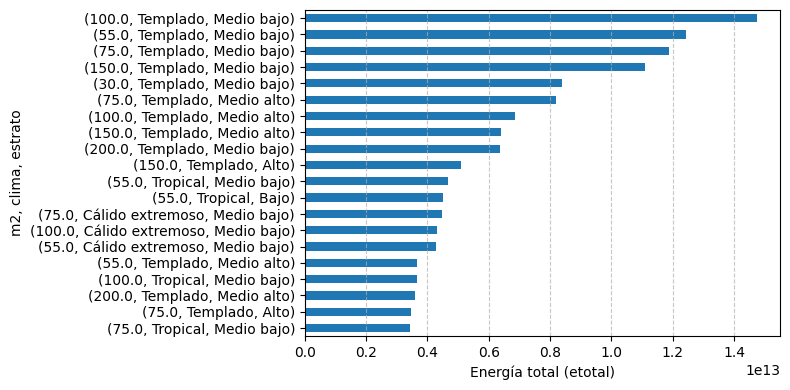

In [19]:

# Prepara Serie normalizada (ya la tienes)
et = (
    tabla_kwh
      .sort_values(by="etotal", ascending=False)
      .set_index(["m2","clima","estrato"])["etotal"]
      .head(20)
)
# et = et / et.max()

# Grafica horizontal
plt.figure(figsize=(8, 4))
# Para que la barra más grande quede arriba, ordena de menor a mayor
et.sort_values().plot(kind='barh')

plt.xlabel("Energía total (etotal)")
plt.ylabel("m2, clima, estrato")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
tabla_kwh.columns

Index(['clima', 'estrato', 'm2', 'n', 'minimo', 'Q1', 'mediana', 'Q3',
       'maximo', 'media', 'porcentaje', 'etotal'],
      dtype='object')

In [21]:
tabla_kwh.clima.unique()

array(['Cálido extremoso', 'Templado', 'Tropical'], dtype=object)

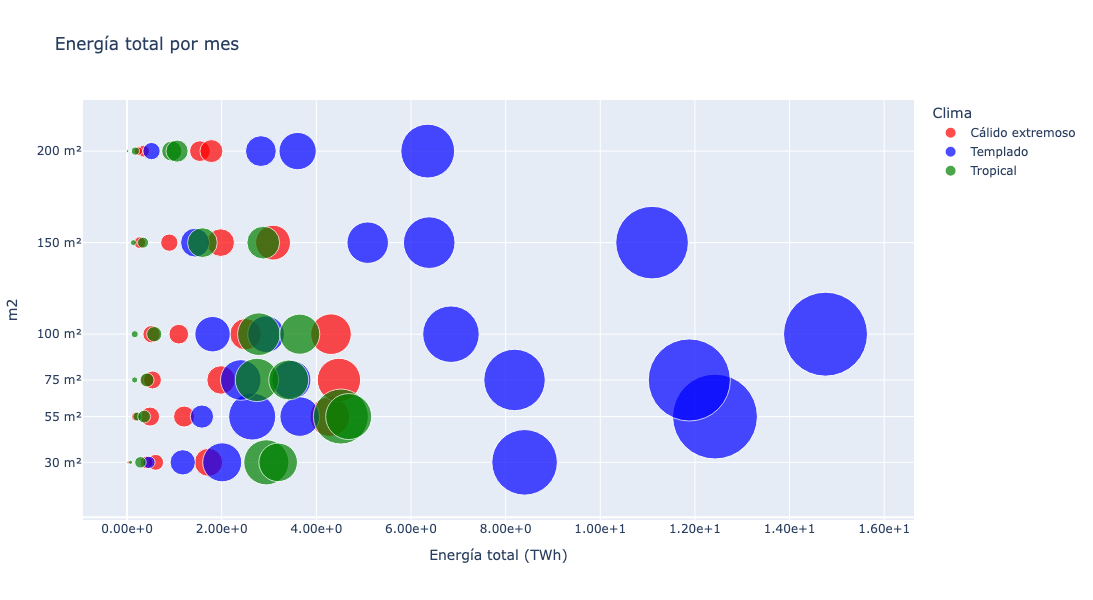

In [23]:

color_map = {
    "Cálido extremoso": "red",
    "Tropical"         : "green",
    "Templado"         : "blue",
}
# Crear gráfica de burbujas: etotal vs porcentaje, tamaño por viviendas, color por clima
fig = px.scatter(
    tabla_kwh,
    x=tabla_kwh['etotal']/1e12,
    y='m2',
    size='porcentaje',
    color='clima',    
    color_discrete_map=color_map,   # ← aquí asignas tus colores
    hover_data=['m2', 'estrato',  'porcentaje', 'etotal'],
    labels={
        'etotal': 'Energía total (TWh)',
        'porcentaje': 'Porcentaje (%)',
        'clima': 'Clima'
    },
    title='Energía total por mes',
    size_max=60
)

fig.update_layout(
    xaxis=dict(tickformat=".2e"),
    yaxis=dict(
        tickmode="array",
        tickvals=[30, 55, 75, 100, 150, 200],
        # opcional: si quieres texto distinto al valor numérico:
        ticktext=["30 m²","55 m²","75 m²","100 m²","150 m²","200 m²"]
    ),
    height=600,
    xaxis_title="Energía total (TWh)",
)

fig.show()
